In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import os
import cv2

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_simpsonCNN_trained_model.h5'

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np

simpson_img = pd.read_csv('/data/examples/simpson_preproc/simpson_img_list.csv')
print(simpson_img.head())


  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg


(200, 200)

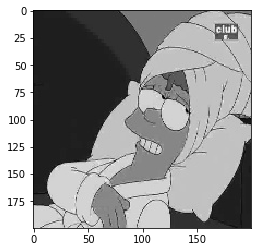

In [3]:
img = cv2.imread('/data/examples/simpson_preproc/' + simpson_img.img.iloc[0], 0)
plt.imshow(img, cmap="gray")
img.shape

In [4]:
simpson_img = simpson_img[simpson_img.img.str.contains('simpson')]
simpson_img.shape
# simpson_img.head(3)

(7274, 2)

In [5]:
simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix()
# print(simpson_img['classname'])
# print(simpson_y)
print(simpson_y.shape)
num_classes = simpson_y.shape[1]


(7274, 6)


In [11]:
# can't handle this case due to the classname is not numeric
# num_classes = 6
# y_train = keras.utils.to_categorical(simpson_img['classname'], num_classes)

In [6]:
x_img = []
for i in range(simpson_y.shape[0]):
    img = cv2.imread('/data/examples/simpson_preproc/' + simpson_img.img.iloc[i], 0)
    img = cv2.resize(img, (50,50))
    x_img.append(img)


In [7]:
# processing data
# conv2D accept the 4D data only
x_ = np.array(x_img)
x_ = x_[:,:,:,np.newaxis]
print(x_.shape)

x_ = np.float32(x_)
x_ /= 255.

(7274, 50, 50, 1)


In [8]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_, simpson_y, test_size=0.1)

## record the dim of img ##
# img = img.flatten()

print('input_data shape: training {training_shape} ; testing {testing_shape}'.format(
                training_shape = x_train.shape, testing_shape=x_test.shape))
print('y_ shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=y_train.shape, testing_shape=y_test.shape))



input_data shape: training (6546, 50, 50, 1) ; testing (728, 50, 50, 1)
y_ shape: training (6546, 6) ; testing (728, 6)


In [9]:
# build our CNN model

model = Sequential()

model.add(Conv2D(64, (5, 5), padding='same',
                 input_shape=x_train[0].shape))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
#------------------------------------------------

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
#------------------------------------------------

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

#------------------------------------------------

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        73792     
__________

In [10]:
# initiate Adam optimizer
opt = keras.optimizers.Adam()

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
batch_size = 256
epochs = 200

In [11]:
print('Using real-time data augmentation.')

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True, 
    vertical_flip=False)


# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)


Using real-time data augmentation.


In [14]:

# Fit the model on the batches generated by datagen.flow().
model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4),
                                    #callbacks=[checkpoint, earlystop])
import pickle
with open('trainHistoryDict4', 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)
        

Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor with shape[256,50,50,64]
	 [[Node: conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_conv2d_1_input_0_2/_149, conv2d_1/kernel/read)]]
	 [[Node: loss/mul/_191 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1257_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'conv2d_1/convolution', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-a130024f148b>", line 6, in <module>
    input_shape=x_train[0].shape))
  File "/opt/conda/lib/python3.6/site-packages/keras/models.py", line 467, in add
    layer(x)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[256,50,50,64]
	 [[Node: conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_conv2d_1_input_0_2/_149, conv2d_1/kernel/read)]]
	 [[Node: loss/mul/_191 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1257_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [38]:
# loading our save model
print("Loading trained model")
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)


# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
728/728 [==============================] - 0s 275us/step
Test loss: 0.319931695913
Test accuracy: 0.89972527407


In [8]:
# import os
# import time
# cwd = os.getcwd() 
# print(cwd)

#reload the model history information
import pickle
model_history = pickle.load(open('trainHistoryDict3', mode='rb'))
print(model_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


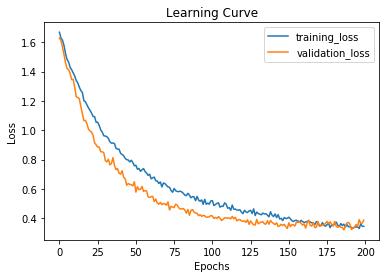

In [13]:
import matplotlib.pyplot as plt
model_history = model_history.history
training_loss = model_history.['loss']
val_loss = model_history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

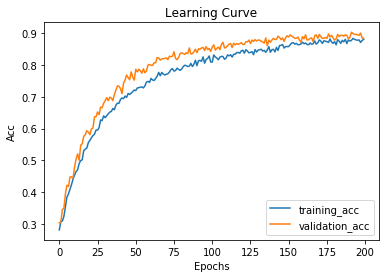

In [12]:

training_acc = model_history['acc']
val_acc = model_history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()